In [ ]:
from dataclasses import dataclass
from typing import Optional
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
def precompute_theta_pos_frequencies(head_dim:int, seq_len:int, device:str, theta:float=10000.0):
    assert head_dim % 2 == 0, "Dimension (divided with head) must be divisible by 2"
    
    theta_numerator = torch.arange(0, head_dim, 2).float()
    theta = 1.0 / (theta ** (theta_numerator / head_dim)).to(device)
    m = torch.arange(seq_len, device=device)
    freqs = torch.outer(m, theta).float() # (seq_len) outer product* (head_dim / 2) -> (seq_len, head_dim/2)
    
    # torch.polar = abs⋅cos(angle)+abs⋅sin(angle)⋅j
    freqs_complex = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_complex

In [ ]:
def apply_rotary_embeddings(x: torch.Tensor, freqs_complex:torch.Tensor, device:str):
    # (B, seq_len, num_heads, head_dim) -> (B, seq_len, num_heads, head_dim/2)
    x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2))
    # (seq_len, head_dim/2) -> (1, seq_len, 1, head_dim/2)
    freqs_complex = freqs_complex.unsqueeze(0).unsqueeze(2)
    # (B, seq_len, num_heads, head_dim/2) * (1, seq_len, 1, head_dim/2) = (B, seq_len, num_heads, head_dim/2)
    x_rotated = x_complex * freqs_complex
    # (B, seq_len, num_heads, head_dim/2) -> (B, seq_len, num_heads, head_dim/2, 2)
    x_out = torch.view_as_real(x_rotated)
    # (B, seq_len, num_heads, head_dim/2, 2) -> (B, seq_len, num_heads, head)
    x_out = x_out.reshape(*x.shape)
    return x_out.type_as(x).to(device)    

In [ ]:
class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-8):
        super().__init__()
        self.dim = dim
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
        
    def _reciprocal_rms(self, x: torch.Tensor):
        '''
        rms(x) = sqrt(mean(x^2))
        reciprocal_rms(x) = x / rms(x)
        '''
        
        # (B, seq_len, dim) * (B,. seq_len, 1) -> (B, seq_len, dim)
        return x * torch.rsqrt(x.pow(2).mean(dim=self.dim, keepdim=True) + self.eps)
    
    def forward(self, x:torch.Tensor):        
        # (dim) * (B, seq_len, dim) -> (B, seq_len, dim)
        return self.weight * self._reciprocal_rms(x).type_as(x)

In [ ]:
@dataclass
class ModelArgs:
    dim: int = 768      # llama: 4096, gpt: 768
    n_layers: int = 4   # llama: 32, gpt: 12
    n_heads: int = 4    # llama: 16, gpt: 12
    n_kv_heads: Optional[int] = None
    vocal_size: int = -1
    multiple_of: int = 4 # llama: 256, gpt: 64
    ffn_dim_multiplier: Optional[float] = None
    norm_eps: float = 1e-6
    
    # needed for KV cache
    max_batch_size: int = 32
    max_seq_len: int = 1024   # llama: 2048, gpt: 1024
    
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    '''
    x: (B, seq_len, dim) -> (B, seq_len, n_rep, dim)
    '''
    
    batch_size, seq_len, n_kv_heads, head_dim = x.shape
    if n_rep == 1:
        return x
    else:
        return (
            x[:, :, :, None, :]
            .expand(batch_size, seq_len, n_kv_heads, n_rep, head_dim)
            .reshape(batch_size, seq_len, n_kv_heads * n_rep, head_dim)
        )

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, args: ModelArgs):
        super().__init__()
        
        # calculate n_heads of Grouped Attention with KV cache
        self.n_kv_heads = args.n_heads if args.n_kv_heads is None else args.n_kv_heads
        self.n_heads_q = args.n_heads
        self.n_rep = self.n_heads_q // self.n_kv_heads
        self.head_dim = args.dim // self.n_heads_q      
        
        self.wq = nn.Linear(args.dim, self.n_heads_q * self.head_dim, bias=False)       
        self.wk = nn.Linear(args.dim, self.n_kv_heads * self.head_dim, bias=False)
        self.wv = nn.Linear(args.dim, self.n_kv_heads * self.head_dim, bias=False)
        self.wo = nn.Linear(args.dim, args.dim, bias=False) 
        
        self.cache_k = torch.zeros((args.max_batch_size, args.max_seq_len, self.n_kv_heads, self.head_dim), device=args.device)
        self.cache_v = torch.zeros((args.max_batch_size, args.max_seq_len, self.n_kv_heads, self.head_dim), device=args.device)
        
    def forward(self, x: torch.Tensor, start_pos: int, freqs_complex: torch.Tensor):
        batch_size, seq_len, _ = x.size() # (B, seq_len, dim)
        
        xq = self.wq(x) # (B, seq_len, dim) -> (B, seq_len, n_heads_q * head_dim)
        xk = self.wk(x) # (B, seq_len, dim) -> (B, seq_len, n_heads_kv * head_dim)
        xv = self.wv(x) # (B, seq_len, dim) -> (B, seq_len, n_heads_kv * head_dim)
        
        xq = xq.view(batch_size, seq_len, self.n_heads_q, self.head_dim) # (B, seq_len, n_heads_q * head_dim) -> (B, seq_len, n_heads_q, head_dim)
        xk = xk.view(batch_size, seq_len, self.n_kv_heads, self.head_dim) # (B, seq_len, n_heads_kv * head_dim) -> (B, seq_len, n_heads_kv, head_dim) 
        xv = xv.view(batch_size, seq_len, self.n_kv_heads, self.head_dim) # (B, seq_len, n_heads_kv * head_dim) -> (B, seq_len, n_heads_kv, head_dim)
        
        # position encoding for query, key
        xq = apply_rotary_embeddings(xq, freqs_complex, x.device)
        xk = apply_rotary_embeddings(xk, freqs_complex, x.device)
        
        # Replace the 4entry in the cache with the new values
        self.cache_k[:batch_size, start_pos:start_pos+seq_len] = xk
        self.cache_v[:batch_size, start_pos:start_pos+seq_len] = xv
        
        # (B, seq_len_kv, n_heads_kv, head_dim) 
        keys = self.cache_k[:batch_size, :start_pos+seq_len]
        values = self.cache_v[:batch_size, :start_pos+seq_len]
        
        # repeat the heads of K and V to match the number of heads of Q
        keys = repeat_kv(keys, self.n_rep)
        values = repeat_kv(values, self.n_rep)
        
        # (B, seq_len, n_heads_q, head_dim) -> (B, n_heads_q, seq_len, head_dim)
        xq = xq.transpose(1, 2)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)
        
        # (B, n_heads_q, seq_len, head_dim) * (B, n_heads_q, head_dim, seq_len_kv) -> (B, n_heads_q, seq_len, seq_len_kv)
        scores = torch.matmul(xq, keys.transpose(2, 3) / math.sqrt(self.head_dim))
        scores = F.softmax(scores.float(), dim=-1).type_as(xq)
        
        # (B, n_heads_q, seq_len, seq_len_kv) * (B, n_heads_q, seq_len_kv, head_dim) -> (B, n_heads_q, seq_len, head_dim)
        out = torch.matmul(scores, values)
        
        # (B, n_heads_q, seq_len, head_dim) -> (B, seq_len, n_heads_q, head_dim) -> (B, seq_len, dim)
        out = (out.transpose(1, 2).contiguous().view(batch_size, seq_len, self.n_heads_q * self.head_dim))
        # (B, seq_len, dim) -> (B, seq_len, dim)
        out = self.wo(out) 
        return out 

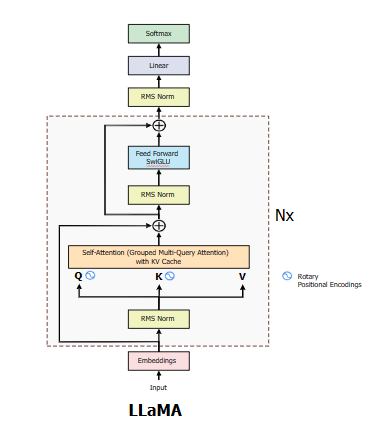

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, args: ModelArgs):
        super().__init__()

        hidden_dim = args.hidden_dim

        self.w1 = nn.Linear(args.dim, hidden_dim, bias=False)
        self.w2 = nn.Linear(hidden_dim, args.dim, bias=False)
        self.w3 = nn.Linear(args.dim, hidden_dim, bias=False)

    def forward(self, x: torch.Tensor):
        # (B, Seq_Len, Dim) --> (B, Seq_Len, Hidden_Dim)
        swish = F.silu(self.w1(x))
        # (B, Seq_Len, Dim) --> (B, Seq_Len, Hidden_Dim)
        x_V = self.w3(x)
        # (B, Seq_Len, Hidden_Dim) * (B, Seq_Len, Hidden_Dim) --> (B, Seq_Len, Hidden_Dim)
        x = swish * x_V
        # (B, Seq_Len, Hidden_Dim) --> (B, Seq_Len, Dim)
        x = self.w2(x)
        return x

In [ ]:
class FeedForward(nn.Module):
    def __init__(
        self,
        args: ModelArgs
    ):
        super().__init__()

        hidden_dim = 4 * args.dim
        hidden_dim = int(2 * hidden_dim / 3)
        if args.ffn_dim_multiplier is not None:
            hidden_dim = int(args.ffn_dim_multiplier * hidden_dim)
        # Round the hidden_dim to the nearest multiple of the multiple_of parameter
        hidden_dim = args.multiple_of * ((hidden_dim + args.multiple_of - 1) // args.multiple_of)

        self.w1 = nn.Linear(args.dim, hidden_dim, bias=False)
        self.w2 = nn.Linear(hidden_dim, args.dim, bias=False)
        self.w3 = nn.Linear(args.dim, hidden_dim, bias=False)

    def forward(self, x: torch.Tensor):
        # (B, Seq_Len, Dim) --> (B, Seq_Len, Hidden_Dim)
        swish = F.silu(self.w1(x))
        # (B, Seq_Len, Dim) --> (B, Seq_Len, Hidden_Dim)
        x_V = self.w3(x)
        # (B, Seq_Len, Hidden_Dim) * (B, Seq_Len, Hidden_Dim) --> (B, Seq_Len, Hidden_Dim)
        x = swish * x_V
        # (B, Seq_Len, Hidden_Dim) --> (B, Seq_Len, Dim)
        x = self.w2(x)
        return x

In [ ]:
class Block(nn.Module):
    def __init__(self, args: ModelArgs):
        super().__init__()
        self.n_heads = args.n_heads
        self.dim = args.dim
        self.head_dim = args.dim // args.n_heads
        
        self.attention = SelfAttention(args)
        self.feed_forward = FeedForward(args)
        
        # PreNorm
        self.attention_norm = RMSNorm(self.dim, eps=args.norm_eps)
        self.ffn_norm = RMSNorm(self.dim, eps=args.norm_eps)
        
    def forward(self, x: torch.Tensor, start_pos: int, freqs_complex: torch.Tensor):        
        # attention
        ## (B, seq_len, dim) + (B, seq_len, dim) -> (B, seq_len, dim)
        y = self.attention_norm(x + self.attention(x, start_pos, freqs_complex))
        
        # feed forward
        ## (B, seq_len, dim) -> (B, seq_len, dim)
        y = self.ffn_norm(y + self.feed_forward(y))
        return y

In [ ]:
class Transformer(nn.Module):

    def __init__(self, args: ModelArgs):
        super().__init__()

        assert args.vocab_size != -1, "Vocab size must be set"

        self.args = args
        self.vocab_size = args.vocab_size
        self.n_layers = args.n_layers
        self.tok_embeddings = nn.Embedding(self.vocab_size, args.dim)

        self.layers = nn.ModuleList()
        for layer_id in range(args.n_layers):
            self.layers.append(Block(args))

        self.norm = RMSNorm(args.dim, eps=args.norm_eps)
        self.output = nn.Linear(args.dim, self.vocab_size, bias=False)

        self.freqs_complex = precompute_theta_pos_frequencies(self.args.dim // self.args.n_heads, self.args.max_seq_len * 2, device=self.args.device)

    def forward(self, tokens: torch.Tensor, start_pos: int):
        # (B, Seq_Len)
        batch_size, seq_len = tokens.shape
        # assert seq_len == 1, "Only one token at a time can be processed"

        # (B, Seq_Len) -> (B, Seq_Len, Dim)
        h = self.tok_embeddings(tokens)

        # Retrieve the pairs (m, theta) corresponding to the positions [start_pos, start_pos + seq_len]
        freqs_complex = self.freqs_complex[start_pos:start_pos + seq_len]
        
        # Consecutively apply all the encoder layers
        for layer in self.layers:
            h = layer(h, start_pos, freqs_complex)
        h = self.norm(h)
        output = self.output(h).float()
        return output

In [ ]:
from sentencepiece import SentencePieceProcessor

tokenizer = SentencePieceProcessor()
tokenizer.Load('llama/tokenizer.model')
tokenizer

In [ ]:
args = ModelArgs()
args.vocab_size = 1024
args

In [ ]:
if args.device == 'cuda':
    torch.set_default_tensor_type(torch.cuda.HalfTensor)  
else:
    torch.set_default_tensor_type(torch.BFloat16Tensor)

In [ ]:
model = Transformer(args).to(args.device)
x_dummy = torch.rand((args.max_batch_size, args.max_seq_len))

model

In [ ]:
x_dummy = torch.randint(low=0, high=args.max_seq_len, size=(args.max_batch_size, args.max_seq_len), device=args.device)

x_dummy

In [ ]:
from tqdm import tqdm

cur_iterator = tqdm(range(1, args.max_seq_len), desc="Generating tokens")
for cur_pos in cur_iterator:
    with torch.no_grad():
        logits = model.forward(x_dummy[:, cur_pos-1:cur_pos], cur_pos)

### INFERENCE CODE

In [ ]:
from typing import Optional
import torch
import time
from pathlib import Path
import json
from sentencepiece import SentencePieceProcessor
from tqdm import tqdm

In [ ]:
from typing import Optional
import torch
import time
from pathlib import Path
import json
from sentencepiece import SentencePieceProcessor
from tqdm import tqdm

class LLaMA:

    def __init__(self, model: Transformer, tokenizer: SentencePieceProcessor, model_args: ModelArgs):
        self.model = model
        self.tokenizer = tokenizer
        self.args = model_args

    @staticmethod
    def build(checkpoints_dir: str, tokenizer_path: str, load_model: bool, max_seq_len: int, max_batch_size: int, device: str):
        prev_time = time.time()
        if load_model:
            checkpoints = sorted(Path(checkpoints_dir).glob("*.pth"))
            assert len(checkpoints) > 0, f"no checkpoint files found in {checkpoints_dir}"
            ckpt_path = checkpoints[0]
            print(f'Loading checkpoint "{ckpt_path}"')
            checkpoint = torch.load(ckpt_path, map_location="cpu")
            print(f"Loaded checkpoint in {time.time() - prev_time:.2f}s")
            prev_time = time.time()
        with open(Path(checkpoints_dir) / "params.json", "r") as f:
            params = json.loads(f.read())

        model_args: ModelArgs = ModelArgs(
            max_seq_len=max_seq_len,
            max_batch_size=max_batch_size,
            device=device,
            **params
        )

        tokenizer = SentencePieceProcessor()
        tokenizer.load(tokenizer_path)
        model_args.vocab_size = tokenizer.vocab_size()
        
        if device == "cuda":
            torch.set_default_tensor_type(torch.cuda.HalfTensor)
        else:
            torch.set_default_tensor_type(torch.BFloat16Tensor)
        
        model = Transformer(model_args).to(device)

        if load_model:
            # The only unmatched key in the checkpoint is rope.freqs. Remove it
            del checkpoint['rope.freqs']
            model.load_state_dict(checkpoint, strict=True)
            print(f"Loaded state dict in {time.time() - prev_time:.2f}s")
        
        return LLaMA(model, tokenizer, model_args)

    def text_completion(self, prompts: list[str], temperature: float = 0.6, top_p: float = 0.9, max_gen_len: Optional[int] = None):
        if max_gen_len is None:
            max_gen_len = self.args.max_seq_len - 1
        # Convert each prompt into tokens
        prompt_tokens = [self.tokenizer.encode(prompt, out_type=int, add_bos=True, add_eos=False) for prompt in prompts]
        # Make sure the batch size is not too large
        batch_size = len(prompt_tokens)
        assert batch_size <= self.args.max_batch_size, f"batch size must be less than or equal to {self.args.max_batch_size}"
        max_prompt_len = max(len(prompt) for prompt in prompt_tokens)
        # Make sure the prompt length is not larger than the maximum sequence length
        assert max_prompt_len <= self.args.max_seq_len, f"prompt length must be less than or equal to {self.args.max_seq_len}"
        total_len = min(self.args.max_seq_len, max_gen_len + max_prompt_len)

        # Create the list that will contain the generated tokens, along with the initial prompt tokens
        pad_id = self.tokenizer.pad_id()
        tokens = torch.full((batch_size, total_len), pad_id, dtype=torch.long, device=device)
        for k, t in enumerate(prompt_tokens):
            # Populate the initial tokens with the prompt tokens
            tokens[k, : len(t)] = torch.tensor(t, dtype=torch.long, device=device)
        
        eos_reached = torch.tensor([False] * batch_size, device=device)
        prompt_tokens_mask = tokens != pad_id # True if the token is a prompt token, False otherwise
        cur_iterator = tqdm(range(1, total_len), desc="Generating tokens")
        for cur_pos in cur_iterator:
            with torch.no_grad():
                logits = self.model.forward(tokens[:, cur_pos-1:cur_pos], cur_pos)
            if temperature > 0:
                # The temperature is applied before the softmax
                probs = torch.softmax(logits[:, -1] / temperature, dim=-1)
                next_token = self._sample_top_p(probs, top_p)
            else:
                # Greedily select the token with the max probability
                next_token = torch.argmax(logits[:, -1], dim=-1)

            next_token = next_token.reshape(-1)
            # Only replace token if it is a padding token
            next_token = torch.where(prompt_tokens_mask[:, cur_pos], tokens[:, cur_pos], next_token)
            tokens[:, cur_pos] = next_token
            # EOS is reached only if we found an EOS token for a padding position
            eos_reached |= (~prompt_tokens_mask[:, cur_pos]) & (next_token == self.tokenizer.eos_id)
            if all(eos_reached):
                break

        out_tokens = []
        out_text = []
        for prompt_index, current_prompt_tokens in enumerate(tokens.tolist()):
            # Cut to the EOS token, if present
            if self.tokenizer.eos_id in current_prompt_tokens:
                eos_idx = current_prompt_tokens.index(self.tokenizer.eos_id)
                current_prompt_tokens = current_prompt_tokens[:eos_idx]
            out_tokens.append(current_prompt_tokens)
            out_text.append(self.tokenizer.decode(current_prompt_tokens))
        return (out_tokens, out_text)
    
    def _sample_top_p(self, probs, p):
        # (B, vocab_size)
        probs_sort, probs_idx = torch.sort(probs, dim=-1, descending=True)
        # (B, vocab_size)
        probs_sum = torch.cumsum(probs_sort, dim=-1)
        # (B, vocab_size)
        # (Substracting "probs_sort" shifts the cumulative sum by 1 position to the right before masking)
        mask = probs_sum - probs_sort > p 
        # Zero out all the probabilities of tokens that are not selected by the Top P
        probs_sort[mask] = 0.0 
        # Redistribute the probabilities so that they sum up to 1.
        probs_sort.div_(probs_sort.sum(dim=-1, keepdim=True))
        # Sample a token (its index) from the top p distribution
        next_token = torch.multinomial(probs_sort, num_samples=1)
        # Get the token position in the vocabulary corresponding to the sampled index
        next_token = torch.gather(probs_idx, -1, next_token) 
        return next_token

In [ ]:
torch.manual_seed(0)

allow_cuda = False
device = 'cuda' if torch.cuda.is_available() and allow_cuda else 'cpu'

prompts = [
    "Simply put, the theory of relativity states that ",
    "If Google was an Italian company founded in Milan, it would",
    # Few shot promt
    """Translate English to French:
    
    sea otter => loutre de mer
    peppermint => menthe poivrée
    plush girafe => girafe peluche
    cheese =>""",
    # Zero shot prompt
    """Tell me if the following person is actually Doraemon disguised as human:
    Name: Umar Jamil
    Decision: 
    """
]

model = LLaMA.build(
    checkpoints_dir='llama/llama-2-7b/',
    tokenizer_path='llama/tokenizer.model',
    load_model=False,
    max_seq_len=1024,
    max_batch_size=len(prompts),
    device=device
)

out_tokens, out_texts = (model.text_completion(prompts, max_gen_len=64))
assert len(out_texts) == len(prompts)
for i in range(len(out_texts)):
    print(f'{out_texts[i]}')
    print('-' * 50)

In [ ]:
!python3 -V

In [ ]:
torch.manual_seed(42)
llama = LLaMA.build("llama-2-7b/",
                    "tokenizer.model", 
                    load_model=True, 
                    max_seq_len=1024, 
                    max_batch_size=3, 
                    device='cpu')

In [ ]:
args = ModelArgs()
args.vocab_size = 1024
args

In [ ]:
model = Modern_Transformer(args)
x_dummy = torch.rand((args.max_batch_size, args.max_seq_len))

model

In [ ]:
x_dummy.shape

In [ ]:
model(x_dummy, 1023)

In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# This software may be used and distributed in accordance with the terms of the Llama 3 Community License Agreement.

import math
from dataclasses import dataclass
from typing import Optional, Tuple

import fairscale.nn.model_parallel.initialize as fs_init
import torch
import torch.nn.functional as F
from fairscale.nn.model_parallel.layers import (
    ColumnParallelLinear,
    RowParallelLinear,
    VocabParallelEmbedding,
)
from torch import nn


@dataclass
class ModelArgs:
    dim: int = 4096
    n_layers: int = 32
    n_heads: int = 32
    n_kv_heads: Optional[int] = None
    vocab_size: int = -1
    multiple_of: int = 256  # make SwiGLU hidden layer size multiple of large power of 2
    ffn_dim_multiplier: Optional[float] = None
    norm_eps: float = 1e-5
    rope_theta: float = 500000

    max_batch_size: int = 32
    max_seq_len: int = 2048


class RMSNorm(torch.nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        return output * self.weight


def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    t = torch.arange(end, device=freqs.device, dtype=torch.float32)
    freqs = torch.outer(t, freqs)
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
    return freqs_cis


def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    ndim = x.ndim
    assert 0 <= 1 < ndim
    assert freqs_cis.shape == (x.shape[1], x.shape[-1])
    shape = [d if i == 1 or i == ndim - 1 else 1 for i, d in enumerate(x.shape)]
    return freqs_cis.view(*shape)


def apply_rotary_emb(
    xq: torch.Tensor,
    xk: torch.Tensor,
    freqs_cis: torch.Tensor,
) -> Tuple[torch.Tensor, torch.Tensor]:
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    freqs_cis = reshape_for_broadcast(freqs_cis, xq_)
    xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3)
    xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3)
    return xq_out.type_as(xq), xk_out.type_as(xk)


def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    """torch.repeat_interleave(x, dim=2, repeats=n_rep)"""
    bs, slen, n_kv_heads, head_dim = x.shape
    if n_rep == 1:
        return x
    return (
        x[:, :, :, None, :]
        .expand(bs, slen, n_kv_heads, n_rep, head_dim)
        .reshape(bs, slen, n_kv_heads * n_rep, head_dim)
    )


class Attention(nn.Module):
    def __init__(self, args: ModelArgs):
        super().__init__()
        self.n_kv_heads = args.n_heads if args.n_kv_heads is None else args.n_kv_heads
        model_parallel_size = fs_init.get_model_parallel_world_size()
        self.n_local_heads = args.n_heads // model_parallel_size
        self.n_local_kv_heads = self.n_kv_heads // model_parallel_size
        self.n_rep = self.n_local_heads // self.n_local_kv_heads
        self.head_dim = args.dim // args.n_heads

        self.wq = ColumnParallelLinear(
            args.dim,
            args.n_heads * self.head_dim,
            bias=False,
            gather_output=False,
            init_method=lambda x: x,
        )
        self.wk = ColumnParallelLinear(
            args.dim,
            self.n_kv_heads * self.head_dim,
            bias=False,
            gather_output=False,
            init_method=lambda x: x,
        )
        self.wv = ColumnParallelLinear(
            args.dim,
            self.n_kv_heads * self.head_dim,
            bias=False,
            gather_output=False,
            init_method=lambda x: x,
        )
        self.wo = RowParallelLinear(
            args.n_heads * self.head_dim,
            args.dim,
            bias=False,
            input_is_parallel=True,
            init_method=lambda x: x,
        )

        self.cache_k = torch.zeros(
            (
                args.max_batch_size,
                args.max_seq_len,
                self.n_local_kv_heads,
                self.head_dim,
            )
        ).cuda()
        self.cache_v = torch.zeros(
            (
                args.max_batch_size,
                args.max_seq_len,
                self.n_local_kv_heads,
                self.head_dim,
            )
        ).cuda()

    def forward(
        self,
        x: torch.Tensor,
        start_pos: int,
        freqs_cis: torch.Tensor,
        mask: Optional[torch.Tensor],
    ):
        bsz, seqlen, _ = x.shape
        xq, xk, xv = self.wq(x), self.wk(x), self.wv(x)

        xq = xq.view(bsz, seqlen, self.n_local_heads, self.head_dim)
        xk = xk.view(bsz, seqlen, self.n_local_kv_heads, self.head_dim)
        xv = xv.view(bsz, seqlen, self.n_local_kv_heads, self.head_dim)

        xq, xk = apply_rotary_emb(xq, xk, freqs_cis=freqs_cis)

        self.cache_k = self.cache_k.to(xq)
        self.cache_v = self.cache_v.to(xq)

        self.cache_k[:bsz, start_pos : start_pos + seqlen] = xk
        self.cache_v[:bsz, start_pos : start_pos + seqlen] = xv

        keys = self.cache_k[:bsz, : start_pos + seqlen]
        values = self.cache_v[:bsz, : start_pos + seqlen]

        # repeat k/v heads if n_kv_heads < n_heads
        keys = repeat_kv(
            keys, self.n_rep
        )  # (bs, cache_len + seqlen, n_local_heads, head_dim)
        values = repeat_kv(
            values, self.n_rep
        )  # (bs, cache_len + seqlen, n_local_heads, head_dim)

        xq = xq.transpose(1, 2)  # (bs, n_local_heads, seqlen, head_dim)
        keys = keys.transpose(1, 2)  # (bs, n_local_heads, cache_len + seqlen, head_dim)
        values = values.transpose(
            1, 2
        )  # (bs, n_local_heads, cache_len + seqlen, head_dim)
        scores = torch.matmul(xq, keys.transpose(2, 3)) / math.sqrt(self.head_dim)
        if mask is not None:
            scores = scores + mask  # (bs, n_local_heads, seqlen, cache_len + seqlen)
        scores = F.softmax(scores.float(), dim=-1).type_as(xq)
        output = torch.matmul(scores, values)  # (bs, n_local_heads, seqlen, head_dim)
        output = output.transpose(1, 2).contiguous().view(bsz, seqlen, -1)
        return self.wo(output)


class FeedForward(nn.Module):
    def __init__(
        self,
        dim: int,
        hidden_dim: int,
        multiple_of: int,
        ffn_dim_multiplier: Optional[float],
    ):
        super().__init__()
        hidden_dim = int(2 * hidden_dim / 3)
        # custom dim factor multiplier
        if ffn_dim_multiplier is not None:
            hidden_dim = int(ffn_dim_multiplier * hidden_dim)
        hidden_dim = multiple_of * ((hidden_dim + multiple_of - 1) // multiple_of)

        self.w1 = ColumnParallelLinear(
            dim, hidden_dim, bias=False, gather_output=False, init_method=lambda x: x
        )
        self.w2 = RowParallelLinear(
            hidden_dim, dim, bias=False, input_is_parallel=True, init_method=lambda x: x
        )
        self.w3 = ColumnParallelLinear(
            dim, hidden_dim, bias=False, gather_output=False, init_method=lambda x: x
        )

    def forward(self, x):
        return self.w2(F.silu(self.w1(x)) * self.w3(x))


class TransformerBlock(nn.Module):
    def __init__(self, layer_id: int, args: ModelArgs):
        super().__init__()
        self.n_heads = args.n_heads
        self.dim = args.dim
        self.head_dim = args.dim // args.n_heads
        self.attention = Attention(args)
        self.feed_forward = FeedForward(
            dim=args.dim,
            hidden_dim=4 * args.dim,
            multiple_of=args.multiple_of,
            ffn_dim_multiplier=args.ffn_dim_multiplier,
        )
        self.layer_id = layer_id
        self.attention_norm = RMSNorm(args.dim, eps=args.norm_eps)
        self.ffn_norm = RMSNorm(args.dim, eps=args.norm_eps)

    def forward(
        self,
        x: torch.Tensor,
        start_pos: int,
        freqs_cis: torch.Tensor,
        mask: Optional[torch.Tensor],
    ):
        h = x + self.attention(self.attention_norm(x), start_pos, freqs_cis, mask)
        out = h + self.feed_forward(self.ffn_norm(h))
        return out


class Transformer(nn.Module):
    def __init__(self, params: ModelArgs):
        super().__init__()
        self.params = params
        self.vocab_size = params.vocab_size
        self.n_layers = params.n_layers

        self.tok_embeddings = VocabParallelEmbedding(
            params.vocab_size, params.dim, init_method=lambda x: x
        )

        self.layers = torch.nn.ModuleList()
        for layer_id in range(params.n_layers):
            self.layers.append(TransformerBlock(layer_id, params))

        self.norm = RMSNorm(params.dim, eps=params.norm_eps)
        self.output = ColumnParallelLinear(
            params.dim, params.vocab_size, bias=False, init_method=lambda x: x
        )

        self.freqs_cis = precompute_freqs_cis(
            params.dim // params.n_heads,
            params.max_seq_len * 2,
            params.rope_theta,
        )

    @torch.inference_mode()
    def forward(self, tokens: torch.Tensor, start_pos: int):
        _bsz, seqlen = tokens.shape
        h = self.tok_embeddings(tokens)
        self.freqs_cis = self.freqs_cis.to(h.device)
        freqs_cis = self.freqs_cis[start_pos : start_pos + seqlen]

        mask = None
        if seqlen > 1:
            mask = torch.full((seqlen, seqlen), float("-inf"), device=tokens.device)

            mask = torch.triu(mask, diagonal=1)

            # When performing key-value caching, we compute the attention scores
            # only for the new sequence. Thus, the matrix of scores is of size
            # (seqlen, cache_len + seqlen), and the only masked entries are (i, j) for
            # j > cache_len + i, since row i corresponds to token cache_len + i.
            mask = torch.hstack(
                [torch.zeros((seqlen, start_pos), device=tokens.device), mask]
            ).type_as(h)

        for layer in self.layers:
            h = layer(h, start_pos, freqs_cis, mask)
        h = self.norm(h)
        output = self.output(h).float()
        return output

In [3]:
args = ModelArgs()
args.vocab_size = 1024
args.n_layers = 4
args.dim = 768
args.n_heads = 4
args.n_kv_heads = 4
args.multiple_of = 4
args

ModelArgs(dim=768, n_layers=4, n_heads=4, n_kv_heads=4, vocab_size=1024, multiple_of=4, ffn_dim_multiplier=None, norm_eps=1e-05, rope_theta=500000, max_batch_size=32, max_seq_len=2048)

In [4]:
model = Transformer(args).to(args.device)
x_dummy = torch.rand((args.max_batch_size, args.max_seq_len))

model

AssertionError: model parallel group is not initialized